In [13]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

Loading the Data

In [14]:
data = pd.read_csv("stock_data.csv")
print(data)

            Date        Open        High         Low       Close   Adj Close  \
0     2018-11-20   44.592499   45.367500   43.877499   44.244999   42.466824   
1     2018-11-20   71.875000   76.737503   71.000000   74.773003   74.773003   
2     2018-11-20  127.029999  134.160004  126.849998  132.429993  132.429993   
3     2018-11-20   22.783333   23.320000   22.236668   23.166000   23.166000   
4     2018-11-21   44.932499   45.067501   44.137501   44.195000   42.418831   
...          ...         ...         ...         ...         ...         ...   
5023  2023-11-16  189.570007  190.960007  188.649994  189.710007  189.710007   
5024  2023-11-17  330.260010  335.500000  329.350006  335.040009  335.040009   
5025  2023-11-17  190.250000  190.380005  188.570007  189.690002  189.690002   
5026  2023-11-17  142.660004  145.229996  142.539993  145.179993  145.179993   
5027  2023-11-17  232.000000  237.389999  226.539993  234.300003  234.300003   

         Volume Company  
0     2713008

In [16]:
data = data[['Date', 'Close']]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5028 non-null   object 
 1   Close   5028 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.7+ KB


Data Time Period

In [17]:
data['Date'].min(), data['Date'].max()

('2018-11-20', '2023-11-17')

Data Visualization

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

Data Preprocessing
1. Splitting the Data

In [23]:
train = data.loc[data['Date'] <= '2021-12-24']
test = data.loc[data['Date'] > '2021-12-24']
train.shape, test.shape

((3116, 2), (1912, 2))

2. Data Scaling

In [24]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

<ipython-input-24-3e103d77f8ae>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-3e103d77f8ae>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



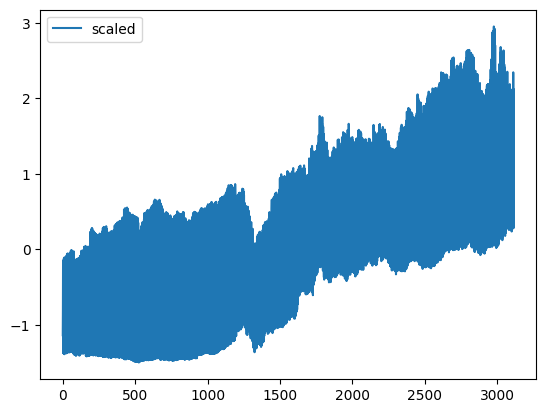

In [25]:
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

3. Creating sequences in the data

In [26]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3086, 30, 1)
Testing input shape:  (1882, 30, 1)


In [28]:
X_train[3056]

array([[0.17935304],
       [1.79990541],
       [0.26484562],
       [2.15177022],
       [0.28584572],
       [0.21824642],
       [1.92317914],
       [2.12956682],
       [0.33944695],
       [1.97838971],
       [2.28879083],
       [0.28373893],
       [2.06500544],
       [0.3273263 ],
       [0.3393743 ],
       [2.35290506],
       [0.31716715],
       [0.32151462],
       [2.05673514],
       [2.11015748],
       [2.05595273],
       [0.37616634],
       [0.29527294],
       [2.15944466],
       [0.2657174 ],
       [2.10892791],
       [0.33470264],
       [1.97086432],
       [0.26039754],
       [2.10054574]])

Building a model

In [29]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

Training the model

In [30]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
87/87 [==============================] - 15s 119ms/step - loss: 0.5431 - val_loss: 0.9573
Epoch 2/100
87/87 [==============================] - 8s 92ms/step - loss: 0.5175 - val_loss: 0.9527
Epoch 3/100
87/87 [==============================] - 9s 109ms/step - loss: 0.5086 - val_loss: 0.9370
Epoch 4/100
87/87 [==============================] - 9s 108ms/step - loss: 0.5084 - val_loss: 0.9355
Epoch 5/100
87/87 [==============================] - 8s 93ms/step - loss: 0.5142 - val_loss: 0.9353
Epoch 6/100
87/87 [==============================] - 9s 105ms/step - loss: 0.5100 - val_loss: 0.9326
Epoch 7/100
87/87 [==============================] - 10s 110ms/step - loss: 0.5061 - val_loss: 0.9301
Epoch 8/100
87/87 [==============================] - 10s 111ms/step - loss: 0.5083 - val_loss: 0.9352
Epoch 9/100
87/87 [==============================] - 8s 93ms/step - loss: 0.5074 - val_loss: 0.9338
Epoch 10/100
87/87 [==============================] - 9s 107ms/step - loss: 0.5063 - val_lo

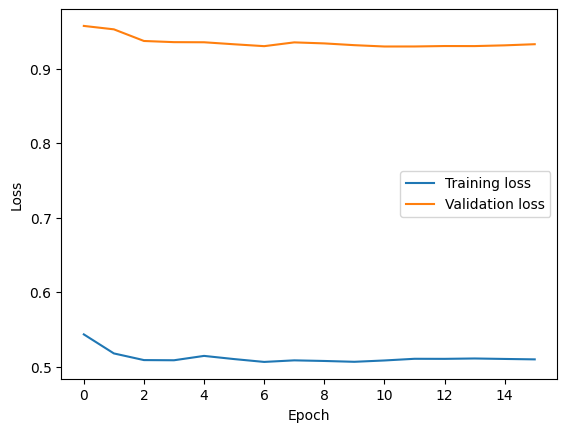

In [31]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

97/97 [==============================] - 4s 31ms/step
Reconstruction error threshold: 1.1332337257294884


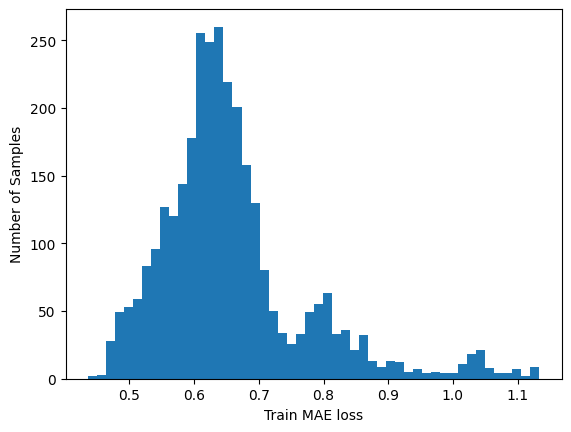

In [32]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

Prediction of Anomalies on test data using threshold value

59/59 [==============================] - 3s 46ms/step


Text(0, 0.5, 'Number of samples')

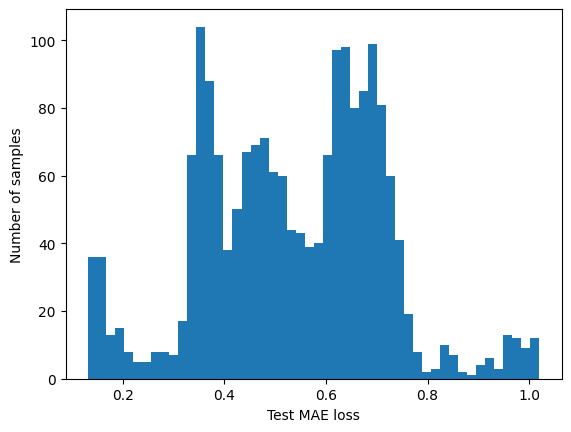

In [33]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [37]:
anomaly_data = pd.DataFrame(test[TIME_STEPS:])
anomaly_data['loss'] = test_mae_loss
anomaly_data['threshold'] = threshold
anomaly_data['anomaly'] = anomaly_data['loss'] > anomaly_data['threshold']

In [38]:
anomaly_data.head()

,Date,Close,loss,threshold,anomaly
3146,2022-01-05,1.993590,1.015709,1.133234,False
3147,2022-01-05,0.207484,0.999517,1.133234,False
3148,2022-01-06,2.337035,1.002021,1.133234,False
3149,2022-01-06,0.292904,1.019405,1.133234,False
3150,2022-01-06,0.195156,1.004787,1.133234,False


In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_data['Date'], y=anomaly_data['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_data['Date'], y=anomaly_data['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [46]:
anomaly_data.shape

(1882, 5)